In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from keras.datasets import cifar10
import seaborn as sns
from skimage import color
import pandas as pd
import os
import matplotlib.image as mpimg

from fastmri_recon.data.test_generators import DataGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.utils import keras_ssim, keras_psnr
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse
from fastmri_recon.helpers.fourier import fft
from fastmri_recon.helpers.utils import gen_mask
from fastmri_recon.helpers.reconstruction import zero_filled_recon
from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


In [2]:
# parameter initialization
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}


AF = 2

In [3]:
def load_data(path):
    path_train = path + "train/"
    path_test = path + "test/"
    train = os.listdir(path_train)
    train_data = []
    for s in train:
        for image in os.listdir(path_train+s):       
            train_data.append(mpimg.imread(path_train+s+'/'+image))

    test = os.listdir(path_test)
    test_data = []
    for s in test:
        for image in os.listdir(path_test+s):          
            test_data.append(mpimg.imread(path_test+s+'/'+image))

    x_train = color.rgb2gray(np.array(train_data))
    x_test = color.rgb2gray( np.array(test_data))

    return x_train, x_test

In [4]:
#load data

path = "/Users/WorkAccount/Desktop/Linnaeus_5_64X64/"

if path != "":
    x_train, x_test = load_data(path)
else:
    (x_train, _), (x_test, _) = cifar10.load_data()
    x_train = color.rgb2gray(x_train)
    x_test = color.rgb2gray(x_test)

im_size = x_train[0].shape[0]

val_gen = DataGenerator(AF, x_test).flow_z_filled_images()
train_gen = DataGenerator(AF, x_train).flow_z_filled_images()

In [5]:
def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [6]:
# model definitions
g = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(g, d, im_size=im_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
# model compiling
perceptual_loss = 'mae'

discriminator_lr = 1e-4
d_on_reconstructor_lr = 1e-4

compile_models(
    d, 
    g, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [8]:
sns.set_style('white')
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=''):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    with sns.color_palette("PuBuGn_d"):
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
            plt.imshow(image, )
            a.set_title(title)
    #plt.colorbar()
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save != '':
        plt.savefig(save)
    plt.show()

In [9]:
n_batches_train = 1000
n_batches_val = 1

run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576260554


/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/data/test_generators.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  kspaces[i, ..., 0] = kspace
/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final[i] = fourier_op.adj_op(kspace)


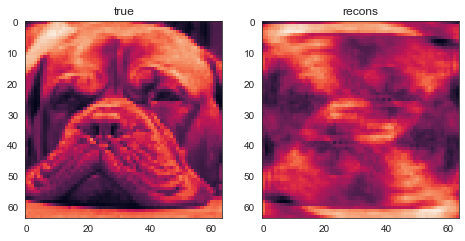

PSNR :  6.0510877371776886
MSE :  0.10027014568901899
NMSE :  0.9931166513937094


/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())


In [10]:
im = next(val_gen)
iim = next(val_gen)
show_images([np.squeeze(im[1]), np.squeeze(im[0])],
            titles = ["true", "recons"])

print("PSNR : ", psnr(np.squeeze(im[1]), np.squeeze(im[0])))
print("MSE : ", mse(im[1], im[0]))
print("NMSE : ", nmse(im[1], im[0]))

In [11]:
log_dir = op.join('logs/training', run_id)

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)
selected_slice = 0
data = next(val_gen)
tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)
gen_tensor = TensorBoard(
    log_dir=log_dir_pre
)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50,
)
tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")
tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=0,
                          verbose=0, mode='auto')

In [12]:
%%time
# %debug
# overfitting trial
hist = adversarial_training_loop(
    g, 
    d, 
    d_on_g, 
    train_gen,
    val_gen,
    n_epochs=0, 
    n_batches=4, 
    n_critic_updates=0,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, earlystop],
    include_d_metrics=True,
    gen_pre_training_steps=250,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre],
)




CPU times: user 2min 49s, sys: 57.3 s, total: 3min 46s
Wall time: 1min 44s


In [13]:
print(run_id)

unet_gan_af2_1576260554


In [14]:
results = g.evaluate_generator(val_gen, steps=100, callbacks=None, verbose=1)

100/100 [==============================] - 3s 29ms/step


In [15]:
print('loss' , 'psnr', 'ssim', 'mse', results)
val_gen = DataGenerator(AF, x_test).flow_z_filled_images()

loss psnr ssim mse [0.11373522132635117, 14.111298561096191, 0.35078904032707214, 0.03612936660647392]


In [16]:
im_alias, im_true = next(val_gen)
im_pred = g.predict(im_alias)

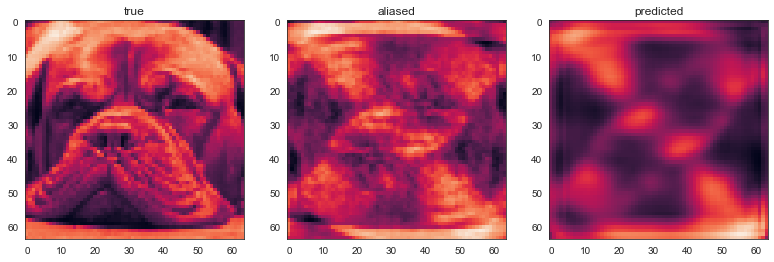

PSNR aliased image:  6.051162591316848 
PSNR predicted image: 13.37776211670648

MSE aliased image:  0.10026841746748513 
MSE predicted image: 0.018556847896081783

NMSE aliased image:  0.9930995343787618 
NMSE predicted image: 0.18379463315168393


In [17]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

In [18]:
print([l for l in hist.history])
print([len(hist.history[l]) for l in hist.history])

['val_loss', 'val_keras_psnr', 'val_keras_ssim', 'val_mse', 'loss', 'keras_psnr', 'keras_ssim', 'mse']
[250, 250, 250, 250, 250, 250, 250, 250]


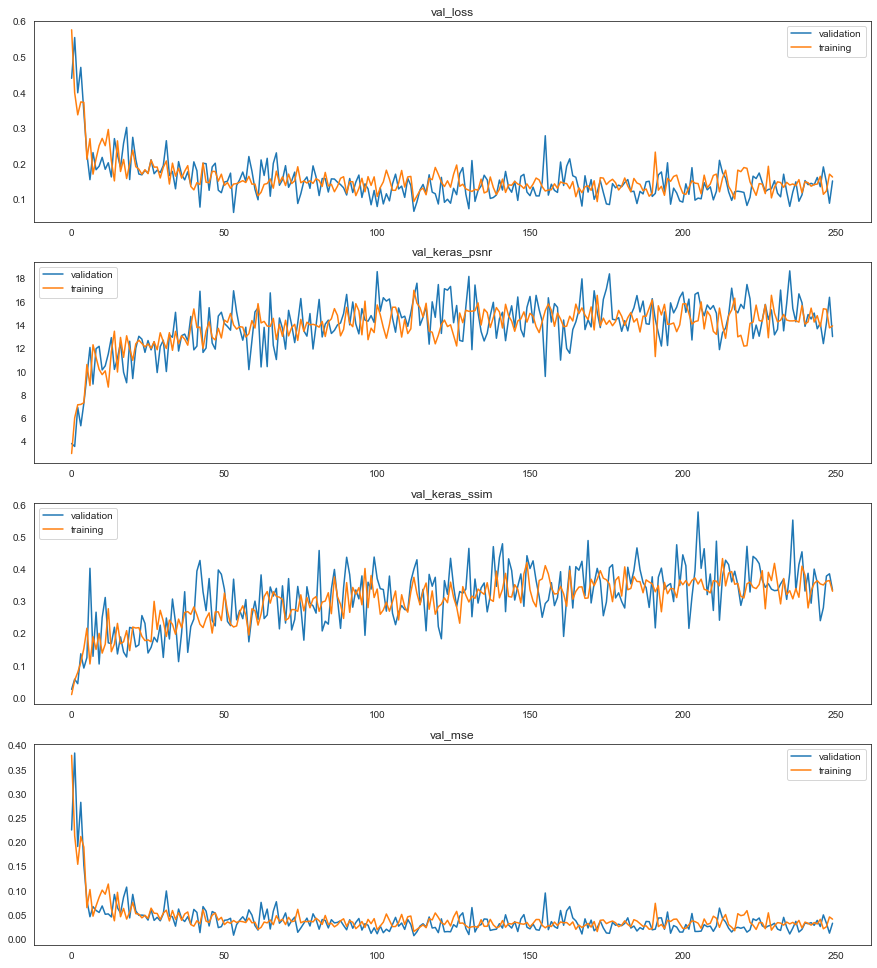

In [19]:
# plot training history

validation = True

fig, axs = plt.subplots(2,2,figsize=(15,17))
images = [hist.history[l] for l in hist.history]
titles = [l for l in hist.history]
if validation==True:
    for i in range(len(titles)//2):
        plt.subplot(4, 1, i+1)
        plt.plot(images[i], label='validation')
        plt.plot(images[i+4], label='training')
        plt.title(titles[i])
        plt.legend()
else:
    for i in range(len(titles)):
        plt.subplot(4, 1, i+1)
        plt.plot(images[i])
        plt.title(titles[i])
plt.show()

In [20]:
# save training history
save_path = ''
hist_df = pd.DataFrame(hist.history) 
hist_json_file = save_path + 'training_history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)